## import Library

In [1]:
!pip install Sastrawi
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tqdm.auto import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from google.colab import drive

## mountain ke drive 

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## prepocessing data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/sentimen analisis/data_new.csv')
data.head()

,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,label
0,pesanan tidak sesuai dengan yang d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
1,pengiriman dan respon super cepat. tapi barang...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
2,barang yang dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
3,"php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,0
4,barang jelek copot&#34; terus tmpat taruh isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,0


In [5]:
data['Ulasan'] = data['Ulasan'].str.lower()

In [6]:
norm = {" dgn " : " dengan ", " gue ": " saya ", " dgn ":" dengan ", "bgmn ":" bagaimana ", ' tdk':' tidak ', ' blum ':' belum ', 'mantaaaaaaaappp':' bagus ', ' josss ':' bagus ', ' thanks ': ' terima kasih ', 'fast':' cepat ', ' dg ':' dengan ', 'trims':' terima kasih ', 'brg':' barang ', 'gx':' tidak ', ' dgn ':' dengan ', ' recommended':' rekomen ', 'recomend':' rekomen ', 'good':' bagus ', 'yg':'yang', 'tpi':'tapi', 'taro':'taruh', 'gmn':'gimana', 'copot&#34;':'copot'}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

data['Ulasan'] = data['Ulasan'].apply(lambda x: normalisasi(x))

In [7]:
data.head()

,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,label
0,pesanan tidak sesuai dengan yang d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
1,pengiriman dan respon super cepat. tapi barang...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
2,barang yang dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
3,"php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,0
4,barang jelek copot terus tmpat taruh isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,0


## labeling

In [8]:
label = []
for index, row in data.iterrows():
  if row["Rating"] == 1 or row["Rating"] == 2:
    label.append(0)
  else :
    label.append(1)

data["label"] = label

In [9]:
data.head()

,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,label
0,pesanan tidak sesuai dengan yang d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
1,pengiriman dan respon super cepat. tapi barang...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
2,barang yang dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
3,"php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,0
4,barang jelek copot terus tmpat taruh isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,0


In [10]:
data.to_csv('/content/drive/MyDrive/sentimen analisis/data.csv', index=False)

## stopwords

In [11]:
stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

data['Ulasan'] = data['Ulasan'].apply(lambda x: stopword(x))
data.head()

,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,label
0,pesanan sesuai yang d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
1,pengiriman respon super cepat. barang sesuai g...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
2,barang dikirim sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,0
3,"php, bilang isi diseskripsi pas dipesen berbed...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,0
4,barang jelek copot terus tmpat taruh isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,0


## tokenize

In [12]:
tokenized = data['Ulasan'].apply(lambda x:x.split())
tokenized

0                      [pesanan, sesuai, yang, d, gambar]
1       [pengiriman, respon, super, cepat., barang, se...
2                      [barang, dikirim, sesuai, pesanan]
3       [php,, bilang, isi, diseskripsi, pas, dipesen,...
4       [barang, jelek, copot, terus, tmpat, taruh, is...
                              ...                        
1920           [bagus, memuaskan., packing, bagus, cepat]
1921             [mantap, pengiriman, cepat, rekomen, ed]
1922                        [pengiriman, cepat., lumayan]
1923              [belom, dicoba, semoga, oke, barangnya]
1924    [barang, cukup, bagus,, respon, bagus., gak, m...
Name: Ulasan, Length: 1925, dtype: object

## stemming

In [13]:
def stemming(Ulasan):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in Ulasan:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

tokenized.to_csv('/content/drive/MyDrive/sentimen analisis/bersih.csv', index=False)
data_clean = pd.read_csv('/content/drive/MyDrive/sentimen analisis/bersih.csv')
data_clean.head()

pesan sesuai yang d gambar
kirim respon super cepat barang sesuai gambar tidak kuat tembus jok motor
barang kirim sesuai pesan
php bilang isi skripsi pas sen beda mubajir rp50 000 nyata isi ga cocok
barang jelek copot terus tmpat taruh isi
beli staples gak jual isi sekali pake ckckck
baik kalau mau ngirim barang periksa dulu gan kondisi barang layak apa gak gitu loh isi karat semua
produk sesuai order prohex kirim
barang sdh terima
bisa buat masang jok gak pake
barang datang cacat gak guna harus sblum kirim di coba dulu
kecewa baru dipakey isiya kluar 2 3 buah papan nempel
barang kurang bagus kirim pakai pos lama sekali
hasil staples rapat bidang mungkin produk cacat hadeeuh
barang standart n biasa aja kurang bagus 
barang rusak kecewa berat
beli 5 bs pakai semua
straples nya gk bs dipake udh coba berkali2 bwt pasang jaring nyamuk straples tembak bah triplek aja gk nembus udh harus diketok2 palu lgi 
mungkin harga juga jadi susah dipake hehe staples gak nancep sampe oenuh
gagal
ggdjkkj

,Ulasan
0,pesan sesuai yang d gambar
1,kirim respon super cepat barang sesuai gambar ...
2,barang kirim sesuai pesan
3,php bilang isi skripsi pas sen beda mubajir rp...
4,barang jelek copot terus tmpat taruh isi


## gabungkan data yang sudah lewat proses stemming dengan label menjadi satu dataset baru

In [14]:
at1 = pd.read_csv('/content/drive/MyDrive/sentimen analisis/bersih.csv')
at2 = pd.read_csv('/content/drive/MyDrive/sentimen analisis/data.csv')
att2 = at2['label']

result = pd.concat([at1, att2], axis=1)

In [15]:
result.head()

,Ulasan,label
0,pesan sesuai yang d gambar,0
1,kirim respon super cepat barang sesuai gambar ...,0
2,barang kirim sesuai pesan,0
3,php bilang isi skripsi pas sen beda mubajir rp...,0
4,barang jelek copot terus tmpat taruh isi,0


In [16]:
result.to_csv('/content/drive/MyDrive/sentimen analisis/result.csv', index=False)

## visualisasi data

In [17]:
train_s0 = result[result["label"] == 0]
train_s0["Ulasan"] = train_s0["Ulasan"].fillna("tidak ada komentar")

<ipython-input-17-f4e30ab85596>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s0["Ulasan"] = train_s0["Ulasan"].fillna("tidak ada komentar")


In [18]:
train_s0.head(100)

,Ulasan,label
0,pesan sesuai yang d gambar,0
1,kirim respon super cepat barang sesuai gambar ...,0
2,barang kirim sesuai pesan,0
3,php bilang isi skripsi pas sen beda mubajir rp...,0
4,barang jelek copot terus tmpat taruh isi,0
...,...,...
95,bintang nilai semua,0
96,batteray hp original batteray cepat habis cepa...,0
97,kecewa sama barang order tanya warna merah kat...,0
98,baterai baru hari udh bau gosong untung ga ledak,0


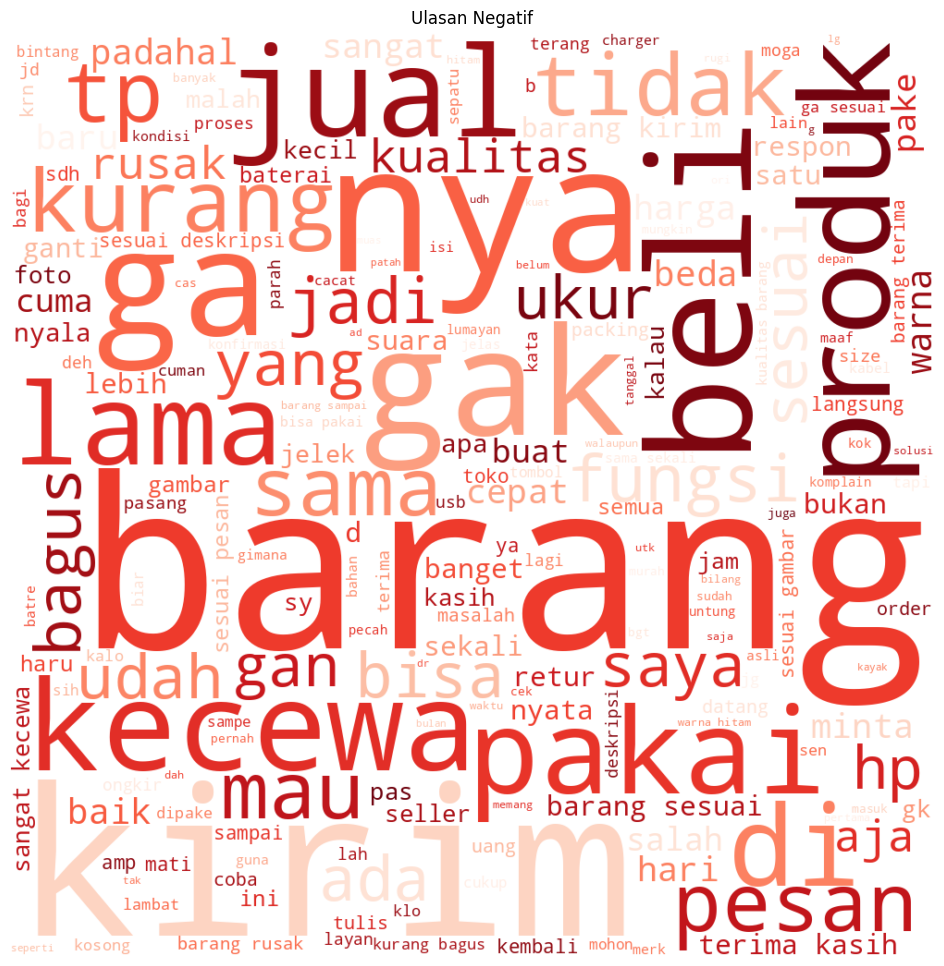

In [19]:
all_text_s0 = ' '.join(word for word in train_s0["Ulasan"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Negatif")
plt.margins(x=0, y=0)
plt.show()

In [20]:
train_s1 = result[result["label"] == 1]
train_s1["Ulasan"] = train_s1["Ulasan"].fillna("Tidak ada komentar")

<ipython-input-20-7cc2e2e704b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s1["Ulasan"] = train_s1["Ulasan"].fillna("Tidak ada komentar")


In [21]:
train_s1.head(100)

,Ulasan,label
925,barang sesuai pesan cepat,1
926,barang bagus harga murah,1
927,paket rapi mantap cepat sampe tuju,1
928,saya puas barang,1
929,responya luar biasa b mantap,1
...,...,...
1020,langsung pakai mantap thanks maaf baru kasi testi,1
1021,harga murah tp isi lumayan banyak n kuat pesan...,1
1022,ok,1
1023,terimakasih barang sdh terima,1


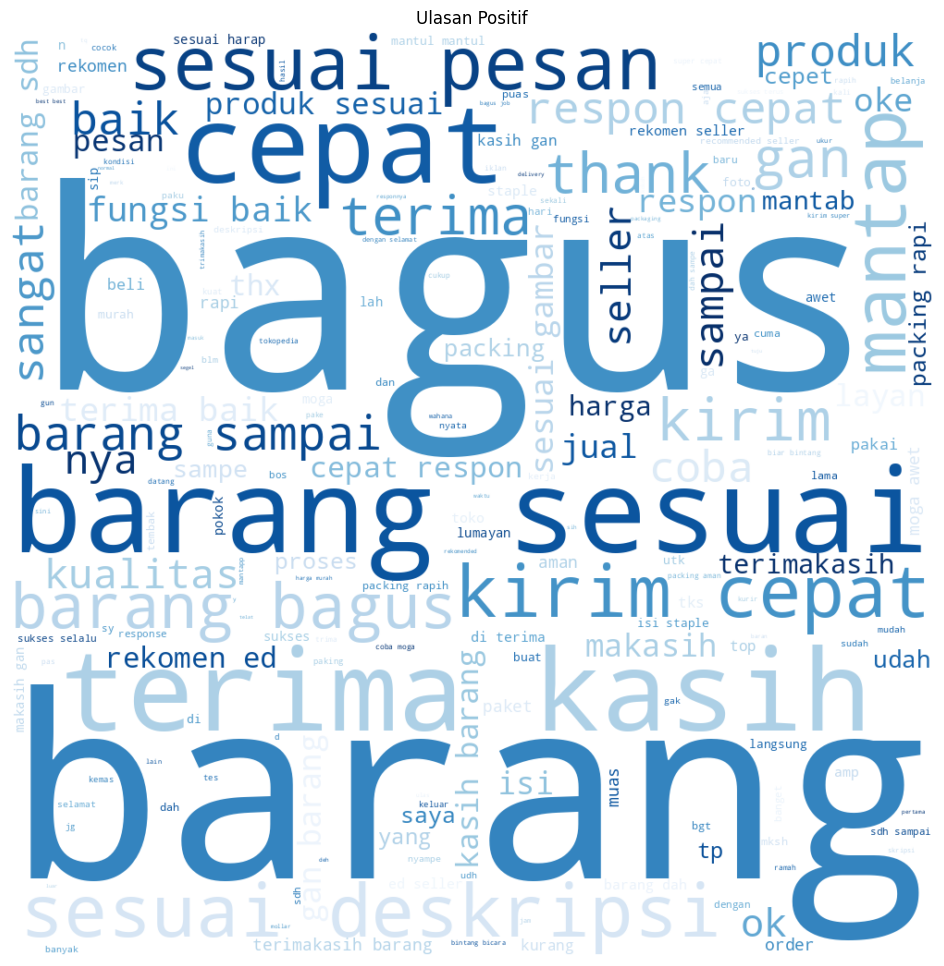

In [22]:
all_text_s1 = ' '.join(word for word in train_s1["Ulasan"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Ulasan Positif")
plt.margins(x=0, y=0)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

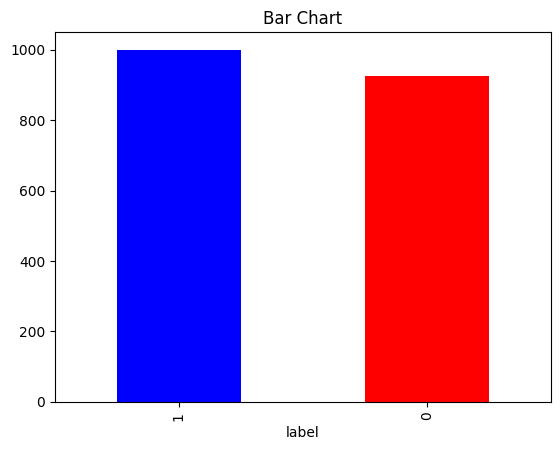

In [23]:
sentimen_data = pd.value_counts(result["label"], sort=True)
sentimen_data.plot(kind='bar', color=['blue', 'red', 'green'])
plt.title("Bar Chart")
plt.show

## modeling dengan indoBERT

In [24]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Ulasan']
        self.labels = dataframe['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }

In [25]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
MAX_LEN = 128
BATCH_SIZE = 16

dataset = CustomDataset(result, tokenizer, MAX_LEN)
train_size = 0.8
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(train_size*len(dataset)), len(dataset) - int(train_size*len(dataset))])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [27]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/291 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## evaluasi model

In [29]:
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

In [30]:
model.eval()

all_preds = []
all_labels = []

for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

In [31]:
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)
print("\nF1 Score:")
print(f1)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[172  18]
 [ 15 180]]

F1 Score:
0.9142718297759098

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       190
           1       0.91      0.92      0.92       195

    accuracy                           0.91       385
   macro avg       0.91      0.91      0.91       385
weighted avg       0.91      0.91      0.91       385



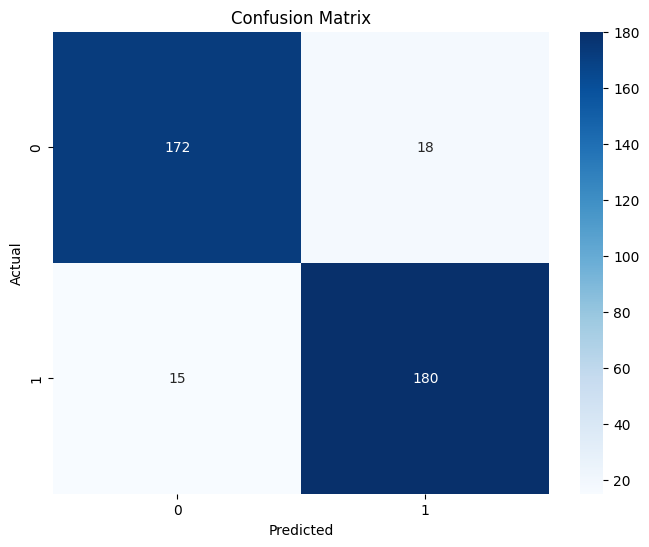

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()